# Phân tích các lỗi dự đoán sai

In [2]:
import os
import random
import time
import math
import subprocess
from glob import glob
import operator
import numpy as np
import pandas as pd
from collections import Counter

import tensorflow as tf
from tensorflow.keras import backend as K
import keras
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os.path as path
lib_path =  path.abspath(path.join('' ,"../../api/common"))
sys.path.insert(1, lib_path)
from predict import predict, evaluate
from filter_outlier import filter_outlier_value_range

%load_ext autoreload
%autoreload 2
%load_ext autotime
%load_ext tensorboard
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 0 ns


## 1. Load model

In [3]:
def my_r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()) )

time: 0 ns


In [4]:
model = load_model('improved_model.hdf5', custom_objects={'my_r2_score': my_r2_score})
model

time: 1.28 s


- Thử nghiệm dữ liệu lọc speed bởi Kyori

In [4]:
filter_speed_by_Kyori = pd.read_csv('filter_speed_by_Kyori.csv')
filter_speed_by_Kyori

,race_id,KettoNum
0,1,2005107051
1,1,2005102028
2,1,2005104156
3,1,2005105319
4,1,2005101044
...,...,...
452416,34534,2012101892
452417,34534,2013104774
452418,34534,2012101704
452419,34534,2012102404


time: 406 ms


In [20]:
filter_speed_by_Kyori[filter_speed_by_Kyori['race_id']==1]

,race_id,KettoNum
0,1,2005107051
1,1,2005102028
2,1,2005104156
3,1,2005105319
4,1,2005101044
5,1,2005103612
6,1,2005106223
7,1,2005101344
8,1,2005102035
9,1,2005104692


time: 15 ms


In [18]:
race_id = filter_speed_by_Kyori['race_id'].tolist()
KettoNum = filter_speed_by_Kyori['KettoNum'].tolist()
train_data_new = train_data[train_data['race_id'].isin(race_id)]
train_data_new = train_data_new[train_data_new['KettoNum'].isin(KettoNum)]
train_data_new

,race_id,KettoNum,id$Year,ChokyosiCode,BanusiCode,UM_BreederCode,Odds,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,...,KS_ChokyosiCode_365.0,id$JyoCD_1,KS_Syotai_川崎,KS_Syotai_笠松,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed
0,33769,2015103377,2017,1029,132030,400018,194,-0.560600,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.347427,0.455914,0.388900,0.102339,58.468677
1,17992,2008103212,2013,411,675030,373126,443,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.669569,1.573814,2.089644,-0.713997,60.125261
2,3892,2006104580,2009,1065,945004,410313,503,-0.560600,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.285358,0.564184,0.736131,-0.704293,58.299595
3,34437,2011105897,2017,380,382004,14,203,3.318191,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.267795,-0.514645,0.348900,-0.320991,53.386060
4,19817,2009100276,2013,311,813007,110031,135,3.803039,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.366346,-1.837489,-0.609051,-0.604829,52.916858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475565,4690,2006103658,2009,437,851005,103097,3717,-0.803024,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.673984,-1.941640,-1.554156,1.946070,57.352941
475566,32918,2015105371,2017,422,674004,633066,699,-0.075751,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.287645,-1.306805,-0.560539,0.072635,59.198356
475567,76,2005104365,2008,1092,543008,930021,1753,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.827702,-0.876114,-1.207746,0.072635,58.815521
475568,796,2001100757,2008,400,450001,900018,1159,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.065100,-0.408134,-0.174065,1.342005,59.833795


time: 1.09 s


In [19]:
train_data_new[train_data_new['race_id']==1]

,race_id,KettoNum,id$Year,ChokyosiCode,BanusiCode,UM_BreederCode,Odds,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,...,KS_ChokyosiCode_365.0,id$JyoCD_1,KS_Syotai_川崎,KS_Syotai_笠松,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed
8144,1,2005104726,2008,1043,212008,800330,378,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.477105,-1.969648,-0.102931,0.072635,57.600000
18962,1,2005101044,2008,1088,163002,730306,134,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.031913,-0.590500,-0.296894,0.072635,58.457375
92901,1,2005104250,2008,1024,764008,130092,70,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.876749,-1.208484,-0.899606,0.072635,56.544503
119012,1,2005102035,2008,1007,498800,203381,43,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.345452,-0.505058,-0.383748,0.072635,57.986577
134889,1,2005102028,2008,138,498800,203381,81,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.076375,-0.505058,-0.383748,0.072635,58.496953
224075,1,2005107051,2008,437,898009,510075,298,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.673984,-1.643898,-0.841113,0.072635,57.446809
278200,1,2005101937,2008,1027,897009,374,222,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.409551,-0.251796,-0.329195,0.072635,56.842105
293105,1,2005104692,2008,339,542800,400069,780,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.524900,0.215065,-0.769009,0.072635,57.029703
322299,1,2005103612,2008,436,274002,630540,29,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.745623,-1.246259,-1.796373,0.072635,58.142665
347608,1,2005101344,2008,106,548800,700045,242,-1.045448,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.788391,-1.723035,-1.750982,0.072635,56.992084


time: 31 ms


In [25]:
y_train_df = pd.read_csv('..\\model and improve\\y_train_df_best.csv')
y_train_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2017,33769,2015103377,58.468677,86.20,5,0
1,2013,17992,2008103212,60.125261,71.85,6,0
2,2009,3892,2006104580,58.299595,86.45,9,0
3,2017,34437,2011105897,53.386060,202.30,7,0
4,2013,19817,2009100276,52.916858,217.70,12,0
...,...,...,...,...,...,...,...
475565,2009,4690,2006103658,57.352941,81.60,8,0
475566,2017,32918,2015105371,59.198356,97.30,3,1
475567,2008,76,2005104365,58.815521,73.45,6,0
475568,2008,796,2001100757,59.833795,72.20,13,0


time: 406 ms


In [5]:
# Load dữ liệu
test_data = pd.read_csv('..\\model and improve\\test_data_best.csv')
test_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,KS_ChokyosiCode_365.0,id$JyoCD_1,KS_Syotai_川崎,KS_Syotai_笠松,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed
0,34535,2015101022,2018,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,...,0.0,0.0,0.0,0.0,0.0,0.398525,-0.217069,0.170224,-0.638792,58.064516
1,34535,2015103483,2018,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.416238,-0.318523,-1.717005,4.067572,57.908847
2,34535,2015106010,2018,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.351520,-2.011989,-0.232397,-0.547818,59.178082
3,34535,2015102342,2018,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.813268,-0.653758,-1.837052,0.188461,58.775510
4,34535,2015102323,2018,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.470225,-0.723485,-0.230435,-0.456845,57.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19216,35925,2014105425,2018,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,...,0.0,0.0,0.0,0.0,0.0,0.251921,1.811396,1.334356,-0.671542,58.378378
19217,35925,2014105543,2018,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,...,0.0,0.0,0.0,0.0,0.0,1.897903,2.023594,1.334356,-0.698228,57.857143
19218,35925,2011106130,2018,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.608702,0.872933,-1.449571,1.291060,57.754011
19219,35925,2012102418,2018,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,...,0.0,0.0,0.0,0.0,0.0,1.897903,0.944895,0.435177,-0.701867,57.497782


time: 375 ms


In [7]:
y_test_df = pd.read_csv('..\\model and improve\\y_test_df_best.csv')
y_test_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2018,34535,2015101022,58.064516,74.4,10,0
1,2018,34535,2015103483,57.908847,74.6,11,0
2,2018,34535,2015106010,59.178082,73.0,2,1
3,2018,34535,2015102342,58.775510,73.5,6,0
4,2018,34535,2015102323,57.142857,75.6,16,0
...,...,...,...,...,...,...,...
19216,2018,35925,2014105425,58.378378,111.0,1,1
19217,2018,35925,2014105543,57.857143,112.0,5,0
19218,2018,35925,2011106130,57.754011,112.2,6,0
19219,2018,35925,2012102418,57.497782,112.7,8,0


time: 31 ms


- Create X, y data

In [8]:
ref_col = ['ChokyosiCode', 'BanusiCode', 'UM_BreederCode', 'Odds']
drop_columns = ['race_id', 'KettoNum', 'id$Year', 'speed'] + ref_col
X_train = train_data.drop(drop_columns, axis=1)
X_train

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_Syotai_フランス,KS_ChokyosiCode_365.0,id$JyoCD_1,KS_Syotai_川崎,KS_Syotai_笠松,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds
0,-0.560600,0.0,1.0,0.0,0.0,-1.550193,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.347427,0.455914,0.388900,0.102339
1,-1.045448,0.0,1.0,0.0,1.0,1.080027,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.669569,1.573814,2.089644,-0.713997
2,-0.560600,0.0,1.0,0.0,0.0,0.203287,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.285358,0.564184,0.736131,-0.704293
3,3.318191,1.0,0.0,1.0,0.0,-0.673453,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.267795,-0.514645,0.348900,-0.320991
4,3.803039,0.0,0.0,1.0,1.0,-0.673453,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.366346,-1.837489,-0.609051,-0.604829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475565,-0.803024,0.0,1.0,0.0,1.0,-1.550193,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.673984,-1.941640,-1.554156,1.946070
475566,-0.075751,1.0,0.0,1.0,0.0,-0.381206,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.287645,-1.306805,-0.560539,0.072635
475567,-1.045448,0.0,1.0,0.0,0.0,-1.257946,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.827702,-0.876114,-1.207746,0.072635
475568,-1.045448,0.0,1.0,0.0,1.0,1.080027,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.065100,-0.408134,-0.174065,1.342005


time: 266 ms


In [9]:
y_train = train_data['speed']
y_train.describe()

count    475570.000000
mean         58.393307
std           2.307932
min          21.973550
25%          56.942004
50%          58.536585
75%          59.916782
max          66.666667
Name: speed, dtype: float64

time: 31 ms


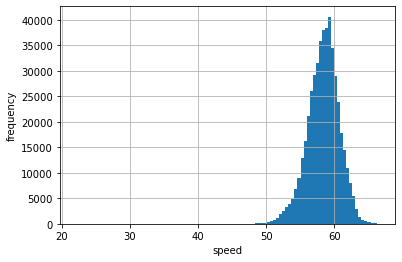

time: 422 ms


In [10]:
y_train.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

In [11]:
drop_columns = ['race_id', 'KettoNum', 'id$Year', 'speed']
X_test = test_data.drop(drop_columns, axis=1)
X_test

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_Syotai_フランス,KS_ChokyosiCode_365.0,id$JyoCD_1,KS_Syotai_川崎,KS_Syotai_笠松,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds
0,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.398525,-0.217069,0.170224,-0.638792
1,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.416238,-0.318523,-1.717005,4.067572
2,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.351520,-2.011989,-0.232397,-0.547818
3,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.813268,-0.653758,-1.837052,0.188461
4,-1.045448,0.0,1.0,0.0,1.0,-1.550193,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.470225,-0.723485,-0.230435,-0.456845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19216,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.251921,1.811396,1.334356,-0.671542
19217,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.897903,2.023594,1.334356,-0.698228
19218,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.608702,0.872933,-1.449571,1.291060
19219,0.409098,0.0,1.0,0.0,1.0,1.664521,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.897903,0.944895,0.435177,-0.701867


time: 47 ms


In [12]:
y_test = test_data['speed']
y_test.describe()

count    19221.000000
mean        58.013356
std          2.304118
min         38.876890
25%         56.509695
50%         58.142665
75%         59.558824
max         65.573770
Name: speed, dtype: float64

time: 16 ms


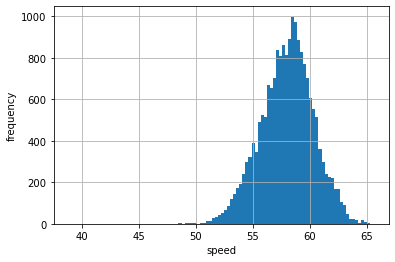

time: 265 ms


In [13]:
y_test.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

## 2. Train with ANN

- Create and compile Model

In [14]:
from tensorflow.keras import backend as K

def my_r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()) )

def BatchNorm():
    return BatchNormalization(
                momentum=0.95, 
                epsilon=0.005,
                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                gamma_initializer=Constant(value=0.9)
                )

#model.add(BatchNorm())
#model.add(Dropout(0.07))
#model.add(Dense(units=num_2, activation='relu'))
#model.add(BatchNorm())     

def build_and_compile_model(X_train, num_units=100, activation='sigmoid'):
    input_shape = X_train.shape[1] 
    model = Sequential()
    model.add(Dense(units=num_units, activation=activation, kernel_initializer='he_normal',
                    input_shape=(input_shape,)))
    #model.add(Dropout(0.07))
    model.add(Dense(1))
      
    model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), my_r2_score], optimizer=Optimizer.Adam(0.01)) #my_r2_score
    
    return model


time: 0 ns


- Setup callback

In [15]:
class My_checkoint(Callback):
        
    def __init__(self, model, X_test, y_test, checkpoint_name):
        self.X_test = X_test
        self.y_test = y_test
        self.mode = model
    def on_epoch_end(self, epoch, logs=None):
        cpn = checkpoint_name + format(epoch, '02d') + '-.hdf5'
        #cpn = os.path.join(checkpoint_dir, 'model'+format(epoch, '02d') + '-.hdf5')
        val_loss = self.mode.evaluate(self.X_test, self.y_test)
        print('my_val_loss', val_loss)
        self.mode.save(cpn)
        
def callback_model(model, checkpoint_name, logdir, X_test, y_test):
  
    _logdir = os.path.join(logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(_logdir, histogram_freq=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.3,
                                  patience=1,
                                  mode='min',
                                  verbose=1)
    
    early_stopping = EarlyStopping(patience=7,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)
    
    csv_logger = CSVLogger('log.log', separator=',', append=False)
    
    callbacks_list = [tensorboard_callback, reduce_lr, early_stopping, csv_logger, My_checkoint(model, X_test, y_test, checkpoint_name)]
    
    return callbacks_list


time: 0 ns


- Create train model

In [16]:
def train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir, batch_size=32, epochs=10, re_train=True):

    if re_train:
        # Clear old folder
        %rmdir /q/s {logdir}
        # Clear old file
        path = checkpoint_name + '**'
        all_path_files = glob(path)
        for file in all_path_files:
            os.remove(file)
        # fit model
        callbacks_list = callback_model(model, checkpoint_name, logdir, X_test, y_test)
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callbacks_list)
        
        #del model
        
    # Get best file by reading log file
    df = pd.read_csv('log.log')
    best_epoch = df.loc[df['val_loss']==df['val_loss'].min(), 'epoch'].values[0]
    best_file = 'model-' + format(best_epoch, '02d') + '-.hdf5'
    #best_file = os.path.join(checkpoint_dir, 'model'+format(best_epoch, '02d') + '-.hdf5')
    model = load_model(best_file, custom_objects={'my_r2_score': my_r2_score})
    return model


time: 0 ns


- Train model

In [17]:
checkpoint_name = 'model-'
baseDir = os.path.abspath(os.getcwd())
logs_name = 'training_logs'
logdir = os.path.join(baseDir, logs_name)
#checkpoint_dir = os.path.join(baseDir, checkpoint_name)
model = build_and_compile_model(X_train, num_units=125, activation='sigmoid')

model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                    batch_size=128, epochs=15, re_train=True)


The system cannot find the file specified.
The system cannot find the path specified.
The system cannot find the file specified.
The system cannot find the path specified.


Epoch 1/15
   1/3716 [..............................] - ETA: 0s - loss: 3480.4163 - root_mean_squared_error: 58.9951 - my_r2_score: -876.2447WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
151/151 [==============================] - 0s 2ms/step - loss: 0.7524 - root_mean_squared_error: 0.8674 - my_r2_score: 0.7896
my_val_loss [0.7524293661117554, 0.867426872253418, 0.7896196246147156]
3716/3716 [==============================] - 11s 3ms/step - loss: 19.7139 - root_mean_squared_error: 4.4400 - my_r2_score: -2.8412 - val_loss: 0.7524 - val_root_mean_squared_error: 0.8674 - val_my_r2_score: 0.7896
Epoch 2/15
3716/3716 [==============================] - ETA: 0s - loss: 0.6490 - root_mean_squared_error: 0.8056 - my_r2_score: 0.8774
Epoch 00002: Reduc

- Evaluate model

In [18]:
# On train
train_result_df = evaluate(model, X_train, y_train_df)
#train_result_df

Sai số rmse:                    0.791
Hệ số xác định r2-score: 0.883
Tỉ lệ True positive:           0.416
time: 28.5 s


In [19]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)
#test_result_df

Sai số rmse:                    0.834
Hệ số xác định r2-score: 0.869
Tỉ lệ True positive:           0.405
time: 438 ms


In [20]:
log_data = pd.read_csv('log.log')
log_data['epoch'] = log_data['epoch'] + 1
log_data

,epoch,loss,lr,my_r2_score,root_mean_squared_error,val_loss,val_my_r2_score,val_root_mean_squared_error
0,1,19.713940,0.010000,-2.841214,4.440038,0.752429,0.789620,0.867427
1,2,0.648963,0.010000,0.877409,0.805583,0.827741,0.767420,0.909803
2,3,0.611036,0.003000,0.884917,0.781688,0.695804,0.805530,0.834149
3,4,0.600750,0.003000,0.886647,0.775080,0.794050,0.775557,0.891095
4,5,0.578439,0.000900,0.891062,0.760552,0.703467,0.802725,0.838729
5,6,0.569106,0.000270,0.892752,0.754391,0.716951,0.798780,0.846729
6,7,0.565749,0.000081,0.893386,0.752163,0.709358,0.801445,0.842234
7,8,0.564750,0.000024,0.893667,0.751499,0.714924,0.799600,0.845531
8,9,0.564401,0.000007,0.893772,0.751266,0.716672,0.799118,0.846565
9,10,0.564291,0.000002,0.893747,0.751193,0.715991,0.799321,0.846163


time: 15 ms


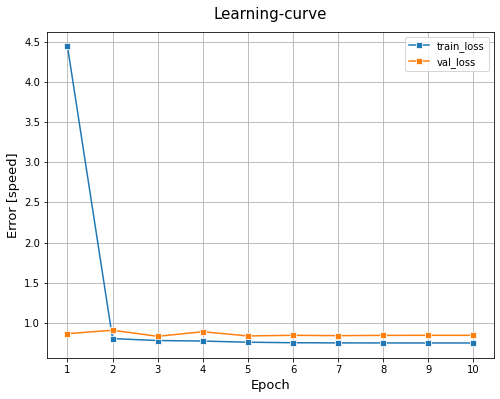

time: 312 ms


In [21]:
def plot_loss(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='root_mean_squared_error', data=log_data, marker='s', label='train_loss');
    sns.lineplot(x='epoch', y='val_root_mean_squared_error', data=log_data, marker='s', label='val_loss');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('Error [speed]', size=13)
    plt.legend()
    plt.title('Learning-curve', size=15, y=1.02)
    plt.grid(True)

plot_loss(log_data)

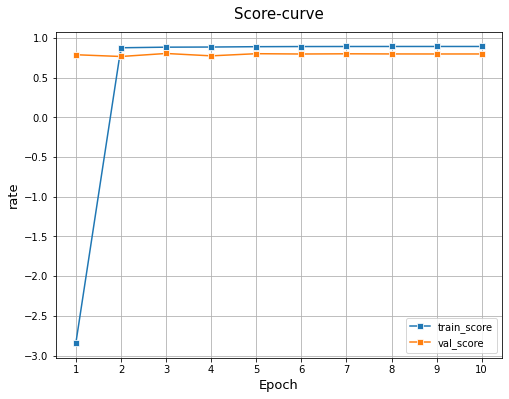

time: 281 ms


In [22]:
def plot_r2(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='my_r2_score', data=log_data, marker='s', label='train_score');
    sns.lineplot(x='epoch', y='val_my_r2_score', data=log_data, marker='s', label='val_score');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('rate', size=13)
    plt.legend()
    plt.title('Score-curve', size=15, y=1.02)
    plt.grid(True)

plot_r2(log_data)

## 3. Phân tích lỗi sai
- Tìm hiểu hành vi sai lỗi của những trường hợp dự đoán nhầm

In [23]:
analys_df = test_result_df
analys_df['check'] = analys_df['top3'] == analys_df['top3_pred']
top3_pred = analys_df[ analys_df['top3_pred']==1] #~
top3_pred

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred,check
0,2018,34535,2015104603,59.259259,72.90,1,1,58.504616,1,1,True
1,2018,34535,2015101022,58.064516,74.40,10,0,58.338200,2,1,False
2,2018,34535,2015104342,58.695652,73.60,7,0,58.312862,3,1,False
16,2018,34536,2015103388,58.855586,73.40,2,1,58.356380,1,1,True
17,2018,34536,2015102477,59.504132,72.60,1,1,58.223495,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...
19191,2018,35924,2014101854,56.799399,133.10,7,0,57.124130,2,1,False
19192,2018,35924,2013105498,56.842105,133.00,6,0,57.086151,3,1,False
19206,2018,35925,2014105543,57.857143,112.00,5,0,57.594921,1,1,False
19207,2018,35925,2014102522,57.319770,113.05,10,0,57.563480,2,1,False


time: 16 ms


In [24]:
top3_test = analys_df[ analys_df['top3']==1]
top3_test

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred,check
0,2018,34535,2015104603,59.259259,72.90,1,1,58.504616,1,1,True
3,2018,34535,2015106010,59.178082,73.00,2,1,58.211483,4,0,False
4,2018,34535,2015105549,59.016393,73.20,3,1,58.158588,5,0,False
16,2018,34536,2015103388,58.855586,73.40,2,1,58.356380,1,1,True
17,2018,34536,2015102477,59.504132,72.60,1,1,58.223495,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...
19194,2018,35924,2014101512,57.186082,132.20,1,1,57.048203,5,0,False
19199,2018,35924,2011106481,57.013575,132.60,2,1,56.979942,10,0,False
19208,2018,35925,2014105425,58.378378,111.00,1,1,57.512501,3,1,True
19209,2018,35925,2014105850,57.908847,111.90,3,1,57.484013,4,0,False


time: 16 ms


In [25]:
top3_train = y_train_df[y_train_df['top3']==1]
top3_train

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
6,2015,25791,2011103545,59.040590,121.95,3,1
7,2010,7308,2007100637,56.665027,101.65,2,1
9,2011,13232,2007101565,61.103253,70.70,1,1
10,2016,30014,2014106056,59.113300,91.35,2,1
12,2008,651,2003102608,59.454996,121.10,2,1
...,...,...,...,...,...,...,...
475536,2013,18056,2007102468,54.129264,222.80,1,1
475546,2016,28736,2011109010,57.036347,107.30,2,1
475558,2011,13158,2008102882,58.731924,134.85,2,1
475564,2012,15712,2009110002,60.965284,59.05,1,1


time: 15 ms


In [26]:
top3_False = analys_df[~analys_df['check']]
top3_False

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred,check
1,2018,34535,2015101022,58.064516,74.40,10,0,58.338200,2,1,False
2,2018,34535,2015104342,58.695652,73.60,7,0,58.312862,3,1,False
3,2018,34535,2015106010,59.178082,73.00,2,1,58.211483,4,0,False
4,2018,34535,2015105549,59.016393,73.20,3,1,58.158588,5,0,False
18,2018,34536,2015102843,57.831325,74.70,7,0,58.159599,3,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19199,2018,35924,2011106481,57.013575,132.60,2,1,56.979942,10,0,False
19206,2018,35925,2014105543,57.857143,112.00,5,0,57.594921,1,1,False
19207,2018,35925,2014102522,57.319770,113.05,10,0,57.563480,2,1,False
19209,2018,35925,2014105850,57.908847,111.90,3,1,57.484013,4,0,False


time: 16 ms


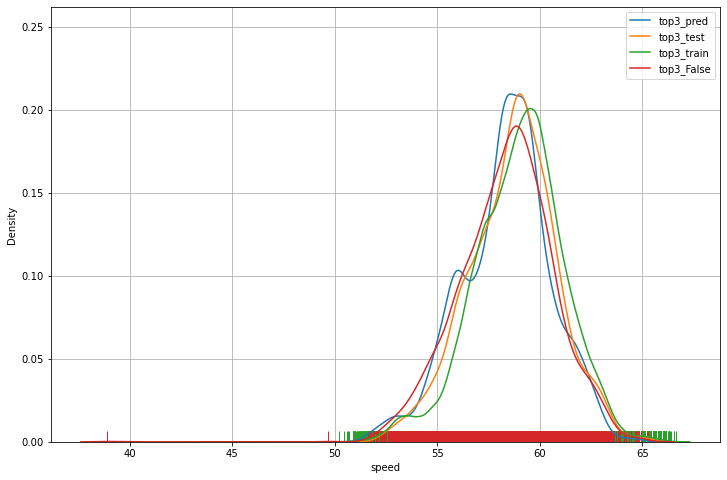

time: 2.2 s


In [27]:

plt.figure(figsize=(12, 8))
sns.distplot(top3_pred['pred_speed'], hist=False, rug=True, label='top3_pred');
sns.distplot(top3_test['speed'], hist=False, rug=True, label='top3_test');
sns.distplot(top3_train['speed'], hist=False, rug=True, label='top3_train');
sns.distplot(top3_False['speed'], hist=False, rug=True, label='top3_False');

plt.grid(True);
plt.legend();


In [28]:
top3_False['race_id'] = top3_False['race_id'].astype('category')
top3_False['KettoNum'] = top3_False['KettoNum'].astype('category')
top3_False['KakuteiJyuni'] = top3_False['KakuteiJyuni'].astype('category')

time: 0 ns


In [29]:
top3_False.describe(include='all')

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred,check
count,4758.0,4758.0,4.758000e+03,4758.000000,4758.000000,4758.0,4758.000000,4758.000000,4758.000000,4758.000000,4758
unique,NaN,1295.0,3.030000e+03,NaN,NaN,18.0,NaN,NaN,NaN,NaN,1
top,NaN,35471.0,2.015104e+09,NaN,NaN,3.0,NaN,NaN,NaN,NaN,False
freq,NaN,7.0,6.000000e+00,NaN,NaN,866.0,NaN,NaN,NaN,NaN,4758
mean,2018.0,NaN,NaN,58.361927,104.479214,NaN,0.502102,58.214489,4.794031,0.497898,NaN
std,0.0,NaN,NaN,2.275431,29.789608,NaN,0.500048,2.241740,3.556214,0.500048,NaN
min,2018.0,NaN,NaN,38.876890,55.150000,NaN,0.000000,51.009335,1.000000,0.000000,NaN
25%,2018.0,NaN,NaN,56.877323,81.950000,NaN,0.000000,56.773948,2.000000,0.000000,NaN
50%,2018.0,NaN,NaN,58.536585,106.800000,NaN,1.000000,58.402210,4.000000,0.000000,NaN
75%,2018.0,NaN,NaN,59.850374,118.700000,NaN,1.000000,59.610460,7.000000,1.000000,NaN


time: 31 ms


In [30]:
Counter(top3_False['race_id']).most_common()

[(34913, 7),
 (35088, 7),
 (35297, 7),
 (35471, 7),
 (35506, 7),
 (34538, 6),
 (34545, 6),
 (34551, 6),
 (34552, 6),
 (34558, 6),
 (34563, 6),
 (34564, 6),
 (34574, 6),
 (34575, 6),
 (34577, 6),
 (34596, 6),
 (34598, 6),
 (34599, 6),
 (34603, 6),
 (34606, 6),
 (34612, 6),
 (34615, 6),
 (34620, 6),
 (34622, 6),
 (34628, 6),
 (34634, 6),
 (34637, 6),
 (34650, 6),
 (34653, 6),
 (34656, 6),
 (34659, 6),
 (34663, 6),
 (34672, 6),
 (34674, 6),
 (34685, 6),
 (34688, 6),
 (34695, 6),
 (34697, 6),
 (34701, 6),
 (34708, 6),
 (34713, 6),
 (34717, 6),
 (34724, 6),
 (34734, 6),
 (34747, 6),
 (34750, 6),
 (34773, 6),
 (34779, 6),
 (34781, 6),
 (34786, 6),
 (34790, 6),
 (34794, 6),
 (34809, 6),
 (34830, 6),
 (34842, 6),
 (34843, 6),
 (34850, 6),
 (34861, 6),
 (34864, 6),
 (34868, 6),
 (34881, 6),
 (34885, 6),
 (34891, 6),
 (34896, 6),
 (34899, 6),
 (34902, 6),
 (34922, 6),
 (34931, 6),
 (34934, 6),
 (34938, 6),
 (34939, 6),
 (34948, 6),
 (34950, 6),
 (34957, 6),
 (34965, 6),
 (34979, 6),
 (34984, 6),

time: 47 ms


In [31]:
Counter(top3_False['KettoNum']).most_common()

[(2015103609, 6),
 (2015100162, 6),
 (2014103367, 6),
 (2015104342, 5),
 (2015105549, 5),
 (2015105621, 5),
 (2013104738, 5),
 (2014104753, 5),
 (2014102505, 5),
 (2014103714, 5),
 (2013100787, 5),
 (2013104933, 5),
 (2014110102, 5),
 (2013105594, 5),
 (2014100428, 5),
 (2013103589, 5),
 (2015103580, 5),
 (2015103362, 5),
 (2015101307, 4),
 (2014104214, 4),
 (2013105535, 4),
 (2015102039, 4),
 (2015102857, 4),
 (2015100166, 4),
 (2015103232, 4),
 (2013100491, 4),
 (2013104166, 4),
 (2013101616, 4),
 (2012103962, 4),
 (2015109002, 4),
 (2015102275, 4),
 (2015104053, 4),
 (2014103937, 4),
 (2014101924, 4),
 (2014105926, 4),
 (2015104344, 4),
 (2015100868, 4),
 (2012102265, 4),
 (2015104159, 4),
 (2013102190, 4),
 (2014109012, 4),
 (2015101326, 4),
 (2013101671, 4),
 (2015102739, 4),
 (2014105605, 4),
 (2014104595, 4),
 (2014104332, 4),
 (2014104304, 4),
 (2015103538, 4),
 (2015105394, 4),
 (2014104001, 4),
 (2014102096, 4),
 (2015105783, 4),
 (2014106256, 4),
 (2015110066, 4),
 (20141053

time: 31 ms


- Trận đấu dự đoán sai nhiều nhất

In [32]:
analys_df[analys_df['race_id']==35471]

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred,check
12879,2018,35471,2015104443,59.320288,97.10,14,0,60.210781,1,1,False
12880,2018,35471,2015104166,59.751037,96.40,5,0,60.160721,2,1,False
12881,2018,35471,2015104912,59.689119,96.50,6,0,60.033474,3,1,False
12882,2018,35471,2015106081,60.188088,95.70,2,1,59.987606,4,0,False
12883,2018,35471,2015104630,59.565667,96.70,10,0,59.984261,5,0,True
12884,2018,35471,2015105276,60.219550,95.65,1,1,59.974140,6,0,False
12885,2018,35471,2015103267,59.596482,96.65,8,0,59.902630,7,0,True
12886,2018,35471,2015100693,60.000000,96.00,3,1,59.896080,8,0,False
12887,2018,35471,2015102439,59.596482,96.65,9,0,59.757782,9,0,True
12888,2018,35471,2015104313,59.596482,96.65,7,0,59.738167,10,0,True


time: 16 ms


- <span style="color:blue">Nhận xét:
    - Ngoài 6 trường hợp False còn thêm trường hợp thứ hạng trong tốp 3 thực tế cùng thành tích    

- Con ngựa bị sai nhiều nhất

In [33]:
analys_df[analys_df['KettoNum']==2014100428]

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred,check
3844,2018,34809,2014100428,58.536585,86.10,8,0,58.229298,7,0,True
3845,2018,34809,2014100428,58.570598,86.05,8,0,58.111313,8,0,True
5197,2018,34907,2014100428,60.083449,71.90,3,1,60.243839,7,0,False
5198,2018,34907,2014100428,60.125261,71.85,3,1,60.233913,8,0,False
7289,2018,35055,2014100428,60.402685,59.60,3,1,60.191990,2,1,True
7290,2018,35055,2014100428,60.453401,59.55,3,1,60.059059,3,1,True
9954,2018,35253,2014100428,60.546601,71.35,1,1,59.587536,3,1,True
9955,2018,35253,2014100428,60.504202,71.40,1,1,59.555664,4,0,False
13671,2018,35524,2014100428,59.568345,69.50,12,0,59.786781,1,1,False
13672,2018,35524,2014100428,59.611231,69.45,12,0,59.771473,2,1,False


time: 0 ns


- <span style="color:blue">Nhận xét:
    - Thành tích bị đảo ngược 100%

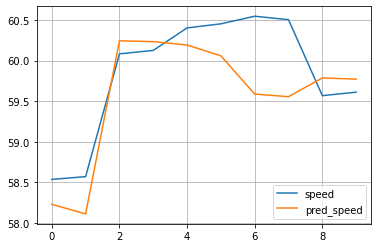

time: 203 ms


In [34]:
analys_df[analys_df['KettoNum']==2014100428].sort_values(by='race_id').reset_index(drop=True)['speed'].plot();
analys_df[analys_df['KettoNum']==2014100428].sort_values(by='race_id').reset_index(drop=True)['pred_speed'].plot();
plt.grid(True);
plt.legend();

- Lọc 80% lỗi sai: Theo speed

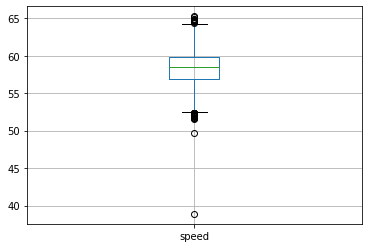

time: 109 ms


In [35]:
top3_False.boxplot(column=['speed']);

In [36]:
top3_False['speed'].describe()

count    4758.000000
mean       58.361927
std         2.275431
min        38.876890
25%        56.877323
50%        58.536585
75%        59.850374
max        65.276519
Name: speed, dtype: float64

time: 0 ns


In [37]:
top3_False['speed'].quantile(q=0.25)

56.87732342007435

time: 0 ns


In [38]:
top3_False['speed'].quantile(q=0.75)

59.850374064837894

time: 0 ns


In [39]:
q1 = top3_False['speed'].quantile(q=0.25)
q3 = top3_False['speed'].quantile(q=0.75)
filter_analys = top3_False[(top3_False['speed']>=q1)&(top3_False['speed']<=q3)]
filter_analys

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred,check
1,2018,34535,2015101022,58.064516,74.40,10,0,58.338200,2,1,False
2,2018,34535,2015104342,58.695652,73.60,7,0,58.312862,3,1,False
3,2018,34535,2015106010,59.178082,73.00,2,1,58.211483,4,0,False
4,2018,34535,2015105549,59.016393,73.20,3,1,58.158588,5,0,False
18,2018,34536,2015102843,57.831325,74.70,7,0,58.159599,3,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19199,2018,35924,2011106481,57.013575,132.60,2,1,56.979942,10,0,False
19206,2018,35925,2014105543,57.857143,112.00,5,0,57.594921,1,1,False
19207,2018,35925,2014102522,57.319770,113.05,10,0,57.563480,2,1,False
19209,2018,35925,2014105850,57.908847,111.90,3,1,57.484013,4,0,False


time: 16 ms


In [40]:
len(filter_analys['race_id'].unique())

789

time: 0 ns


In [41]:
len(top3_False['race_id'].unique())

1295

time: 0 ns


In [42]:
len(filter_analys['KettoNum'].unique())

1743

time: 0 ns


In [43]:
len(top3_False['KettoNum'].unique())

3030

time: 0 ns


- <span style="color:blue">Nhận xét:
    - Có 776 trận đấu chứa các nhân tố chính của sai số so với tổng là 1274 trận đấu
    - Có 1694 con ngựa chứa các nhân tố sai số chính so với tổng số 2991 con ngựa
    - Dải tốc độ phân tích là 56.93 đến 59.90

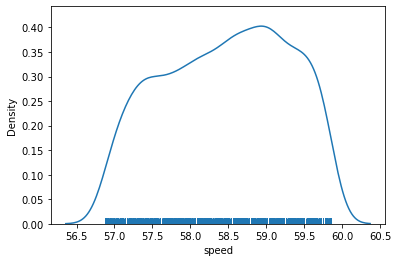

time: 234 ms


In [44]:
sns.distplot(filter_analys['speed'], hist=False, rug=True, label='filter_analys');
#sns.distplot(top3_False['speed'], hist=False, rug=True, label='top3_False');

In [45]:
y_train_df['speed'].quantile(q=0.25)

56.94200351493849

time: 16 ms


In [46]:
y_train_df['speed'].quantile(q=0.75)

59.916782246879336

time: 16 ms


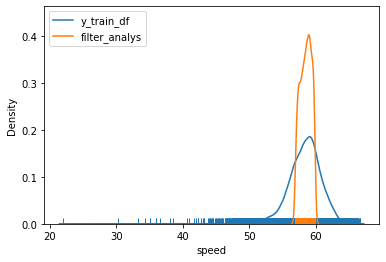

time: 8.53 s


In [47]:
sns.distplot(y_train_df['speed'], hist=False, rug=True, label='y_train_df');
sns.distplot(filter_analys['speed'], hist=False, rug=True, label='filter_analys');
plt.legend()

In [48]:
filter_train = y_train_df[(y_train_df['speed']>=q1)&(y_train_df['speed']<=q3)]
filter_train

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2017,33769,2015103377,58.468677,86.20,5,0
2,2009,3892,2006104580,58.299595,86.45,9,0
6,2015,25791,2011103545,59.040590,121.95,3,1
10,2016,30014,2014106056,59.113300,91.35,2,1
12,2008,651,2003102608,59.454996,121.10,2,1
...,...,...,...,...,...,...,...
475562,2014,21763,2010104944,59.161873,121.70,9,0
475565,2009,4690,2006103658,57.352941,81.60,8,0
475566,2017,32918,2015105371,59.198356,97.30,3,1
475567,2008,76,2005104365,58.815521,73.45,6,0


time: 16 ms


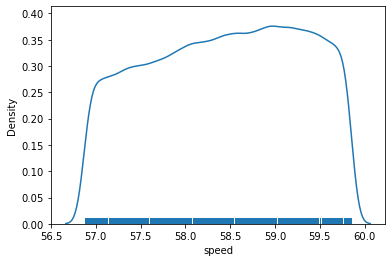

time: 3.08 s


In [49]:
sns.distplot(filter_train['speed'], hist=False, rug=True, label='filter_train');

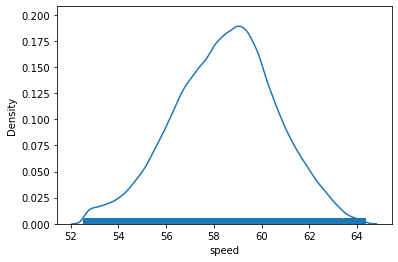

time: 6.64 s


In [50]:
filter_train_test = filter_outlier_value_range(y_train_df, filter_columns=['speed'], threshold_zscore=3, threshold_iqr=1.5)
sns.distplot(filter_train_test['speed'], hist=False, rug=True, label='filter_train_test');

- Save dữ liệu cho phân tích cân bằng dữ liệu

In [52]:
top3_False.to_csv('top3_False.csv', index=False)

time: 47 ms


In [21]:
ttt = top3_False.groupby(['race_id', 'KettoNum'], as_index=False).count()
ttt

NameError: name 'top3_False' is not defined

time: 31 ms
